# Setup

In [8]:
# Setup - import common modules
import sys
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pickle
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix, classification_report

# Configure any plots
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Are we running on local or colab?
if 'edwardrees' in sys.exec_prefix:
    device_loc = 'local'
else:
    device_loc = 'colab'

# Add local drive to path if running on colab
if device_loc == 'local':
    project_dir = '..'
elif device_loc == 'colab':
    
    # Install split folders
    !pip install split_folders
    import split_folders
    
    # Mount drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    project_dir = 'drive/My Drive/GA/Capstone'
    if project_dir not in sys.path:
        sys.path.append(dir_)

# Local directory, i.e up one level from notebooks
local_project_dir = '..'

# Check if using gpu if on colab
if device_loc == 'colab':
    %tensorflow_version 2.x
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
elif device_loc == 'local':
    import tensorflow as tf

# Data loading and processing

## Folder setup

In [4]:
# Define the raw data location
raw_fake_vs_real_dir = local_project_dir+'/data/raw/real_and_fake_face'

# Define the model save/load location
model_dir = local_project_dir+'/models'

# If there is no data in this directory and on colab then copy the data
if device_loc =='colab' and not os.path.exists(raw_fake_vs_real_dir):
   
    # Create the raw data directory if it doesn't exist
    os.makedirs(f'{local_project_dir}/data/raw/')
    
    # Download raw data from github and move it into the raw data directory
    !git clone https://github.com/Rees451/ml-database
    !mv 'ml-database/real_and_fake_face' '{local_project_dir}/data/raw/' && rm -r ./ml-database

# Setup the problem as a ovr problem by running the ovr_file_sorter.py script
# This script seperates photoshopped images for each feature, i.e. eyes, mouth
# and nose
src = f'{local_project_dir}/data/raw'
dest = f'{local_project_dir}/data/processed'
!python '{local_project_dir}/src/ovr_file_sorter.py' $src $dest

Copied 2041 images successfully


In [5]:
# problem specifies what we are trying to classify, for example all indicates 
# that we are trying to classify the whether a face has been photoshopped at all
# left_eye would indicate whether we are trying to classify that the left eye 
# has been photoshopped or not
def train_val_test_split_folders(problem, ratio = (.8, .1, .1), force=False):
    '''
    Write docstring
    '''

    if problem == 'all':
        origin_path = f'{local_project_dir}/data/raw/real_and_fake_face'
    else:
        origin_path = f'{local_project_dir}/data/processed/real_and_fake_face_ovr_links/{problem}'

    problem_path = f'{local_project_dir}/data/processed/sf/{problem}'

    if force:
        !rm -rf $problem_path

    # Copy if doens't allready exist
    if not os.path.exists(problem_path):
        split_folders.ratio(origin_path, problem_path, ratio = (.8, .1, .1))

    # Store the resulting train, test, val paths as strings
    train_dir = problem_path+'/train'
    test_dir = problem_path+'/test'
    val_dir = problem_path+'/val'
    return train_dir, val_dir, test_dir

## Functions

In [6]:
# Function to calculate the baseline accuracy
def baseline(dataset_path):
    n_real = len([i for i in os.listdir(dataset_path+'/real') if '.jpg' in i])
    n_fake = len([i for i in os.listdir(dataset_path+'/fake') if '.jpg' in i])
    print('\n', dataset_path)
    print(n_real, 'real images')
    print(n_fake, 'fake images')
    print(n_real + n_fake, 'images in total')
    print('Baseline of {0:.5f}'.format(max(n_real, n_fake)/(n_real+n_fake)))
    return n_real+n_fake

## Datagen

This section utilies the keras prepocessing functions to load the iamges in an efficent manner

In [37]:
def load_data(train_dir,
              val_dir,
              test_dir,
              train_batch_size=32,
              val_batch_size=32,
              test_batch_size=1,
              img_shape=(64, 64, 3),
              train_args={},
              val_args={}):

    target_size = img_shape[:2]

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1. / 255, **train_args)
    
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1. / 255, **val_args)

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. /
                                                                   255)

    # Trainining dataset generator
    train = train_datagen.flow_from_directory(train_dir,
                                              class_mode="binary",
                                              target_size=target_size,
                                              batch_size=train_batch_size,
                                              shuffle=True,
                                              seed=1)

    # Validation dataset generator
    val = val_datagen.flow_from_directory(val_dir,
                                           class_mode="binary",
                                           target_size=target_size,
                                           batch_size=val_batch_size,
                                           shuffle=True,
                                           seed=1)

    # Test dataset generator
    test = test_datagen.flow_from_directory(test_dir,
                                            class_mode="binary",
                                            target_size=target_size,
                                            batch_size=test_batch_size,
                                            seed=1)

    assert train.class_indices == val.class_indices == test.class_indices
    print(train.class_indices)
    return train, val, test

## Data Visualisation

In [38]:
def inspect_data(imgs, labels, n_required, class_=0):
    i = 0
    n = 0
    fig, ax = plt.subplots(ncols=n_required,
                           nrows=1,
                           figsize=(4 * n_required, 4))
    while i < n_required:
        if int(labels[n]) == class_:
            ax[i].imshow(imgs[n])
            ax[i].axis('off')
            if class_ == 0:
                ax[i].set_title('fake')
            elif class_ == 1:
                ax[i].set_title('real')
            i += 1
        n += 1

In [39]:
problem = 'all'
train_dir, val_dir, test_dir = train_val_test_split_folders(problem, ratio = (.8, .1, .1))

In [40]:
train, val, test = load_data(train_dir, val_dir, test_dir, img_shape=(256,256,3))

Found 1632 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [41]:
imgs, labels = next(train)

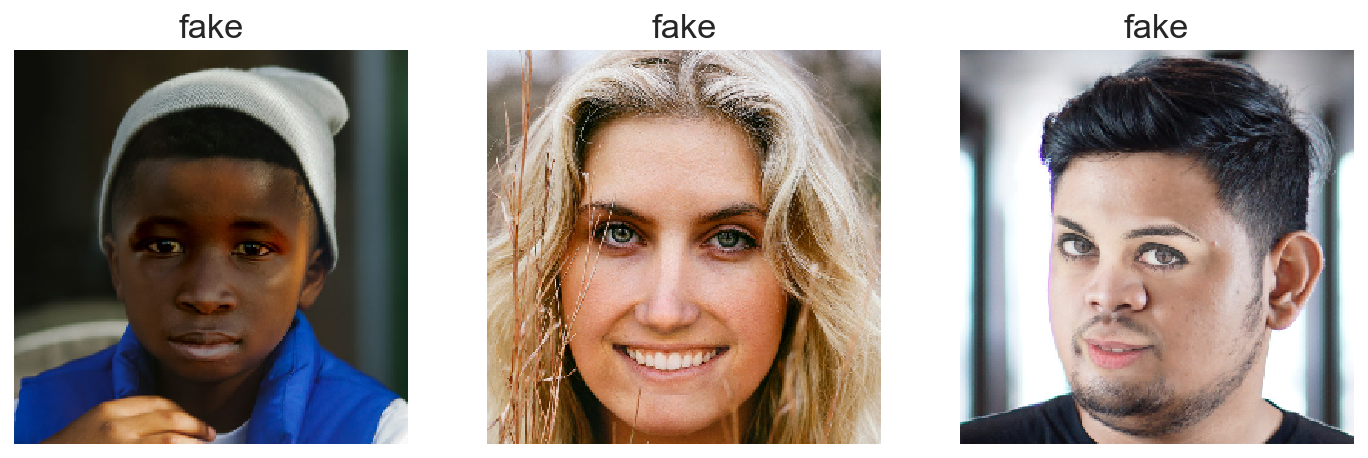

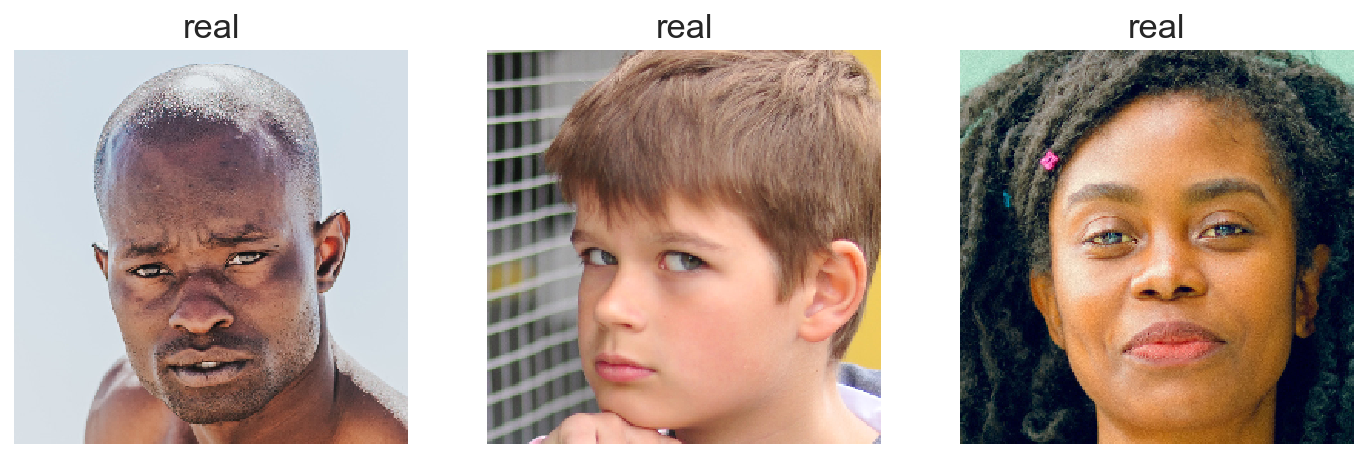

In [172]:
inspect_data(imgs, labels, n_required=3, class_=0)
inspect_data(imgs, labels, n_required=3, class_=1)

In [173]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255, **train_args)

# Modelling

In this section I try out various different models in attempt to find the most robust classifier, I utilise pre-trainined models as well as training my own models from scratch.

### Functions

Some utility functions for the modelling process

In [156]:
# Utility function to plot history of training a network
def plot_training(history):
    train_accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    epoch = range(1, len(train_accuracy)+1)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(epoch, train_accuracy, label = 'Training Accuracy')
    ax.plot(epoch, val_accuracy, label = 'Validation Accuracy')
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    ax.legend()
    plt.legend(framealpha=0);

# Function to return confusion matrix given a model and data
def conf_matrix(model, test):
            predict_labels = model.predict_classes(test[0][0])
            ground_truth = test[0][1]
            
            df = pd.DataFrame(confusion_matrix(ground_truth, predict_labels),
                                columns=['Predicted Fake', ' Predicted Real'], 
                                index = ['Actual Fake', 'Actual Real'])
            display(HTML(df.to_html()))
            
# Function to return the classification summary
def class_report(model, test):
    predict_labels = model.predict_classes(test[0][0])
    ground_truth = test[0][1]
    keys = test.class_indices.keys()
    labels = [test.class_indices[key] for key in keys]

    print(classification_report(ground_truth, predict_labels, labels=labels, target_names=keys))

            
# Function to convert predicted probabilities into class predictions
def prob_to_labels(predict_prob):
        if len(predict_prob[0]) == 1:
            predict_labels = [0 if i > 0.5 else 1 for i in predict_prob]  
        else:
            pass
        return predict_labels

def make_k_layers_trainable(model, k):

    # Number of layers
    n = len(base_model.layers)

    for layer in model.layers[:(n-k)]:
        layer.trainable = False

    return model

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

def save_model(model, name, path=model_dir):
    if not os.path.exists(f'{path}/{name}'):
        os.makedirs(f'{path}/{name}')

    time_now = time.strftime("%Y%m%d-%H%M%S")
    path = f'{path}/{name}/{name}_{time_now}.h5'
    print(path)
    model.save(path)


def load_model(name, path=model_dir):
    pass 

In [72]:
def test_on_difficulty(model,
                       test_dir,
                       dif='',
                       img_shape=img_shape,
                       tests=1000):

    
    fake_paths, real_paths = get_paths(test_dir, dif, n=tests)
    
    fake_imgs = np.zeros((tests,)+img_shape)
    real_imgs = np.zeros((tests,)+img_shape)

    for i, (fake_path, real_path) in enumerate(zip(fake_paths, real_paths)):
        fake_imgs[i],_ = process_path(fake_path, img_shape)
        real_imgs[i],_ = process_path(real_path, img_shape)
        
    fake_imgs = tf.convert_to_tensor(fake_imgs)
    real_imgs = tf.convert_to_tensor(real_imgs)
    
    
    fake_probs = model.predict(fake_imgs)
    real_probs = model.predict(real_imgs)
    
    correct = (fake_probs < real_probs)*1

    return np.mean(correct)

In [28]:
def get_paths(test_dir, dif='hard', n=1):
    real_ls = os.listdir(f'{test_dir}/real')
    fake_ls = os.listdir(f'{test_dir}/fake')
    if dif == 'all':
        fake_d_ls = [f'fake/{i}' for i in fake_ls]
    else:
        fake_d_ls = [f'fake/{i}' for i in fake_ls if dif in i]
    real_d_ls = [f'real/{i}' for i in real_ls]
#     real_d_ls = [f'real/{i}' for i in np.random.choice(real_ls, size=len(fake_d_ls))]
    
    fake_paths = []
    real_paths = []
    for i in range(n):
        fake_path = np.random.choice(fake_d_ls)
        real_path = np.random.choice(real_d_ls)
        fake_paths.append(test_dir+'/'+fake_path)
        real_paths.append(test_dir+'/'+real_path)

    return fake_paths, real_paths

In [27]:
def process_path(path, img_shape):
    if 'fake' in path:
        label = 0
    else:
        label = 1
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize_with_pad(img, img_shape[0], img_shape[1])
    return img, label

## Simple Models

### CNN 1

In [44]:
# Which problem are we looking at?
problem = 'all'

# Train, val, test split by using the function above
train_dir, val_dir, test_dir = train_val_test_split_folders(problem, ratio=(.8, .1, .1))

# Checking the baselines of the splits and return number of images
n_train  = baseline(train_dir)
n_val = baseline(val_dir)
n_test = baseline(test_dir)


 ../data/processed/sf/all/train
864 real images
768 fake images
1632 images in total
Baseline of 0.52941

 ../data/processed/sf/all/val
108 real images
96 fake images
204 images in total
Baseline of 0.52941

 ../data/processed/sf/all/test
109 real images
96 fake images
205 images in total
Baseline of 0.53171


In [161]:
# Model parameters
model_name = 'cnn1'
loss = 'binary_crossentropy'
dropout = 0.1
#learning_rate = 0.02
img_shape = (64, 64, 3)

train_args = {
    'rotation_range': 0,
    'height_shift_range': 0.05,
    'width_shift_range':0.05,
    'horizontal_flip': True,
    'brightness_range': [1.1, 0.9],
    'zoom_range': [1.0, 1.0]
}



# Load data with function defined above
train, val, test = load_data(train_dir,
                             val_dir,
                             test_dir,
                             train_batch_size=16,
                             val_batch_size=16,
                             test_batch_size=n_test,
                             img_shape=img_shape,
                             train_args=train_args,
                             )

# try selu, batch normalisation (decreases the coefficents after each batch), initialisation schemes,
# Specify the model structure
cnn1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3),
                           activation='selu',
                           input_shape=img_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='selu',),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='selu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='selu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam()
cnn1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=15)

# Setup a model checkpoint to save our best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'{model_dir}/{model_name}.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
)

Found 1632 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [86]:
model_fit = cnn1.fit_generator(train, 
                             epochs = 60, 
                             validation_data = val, 
                             callbacks=[checkpoint, es])

Epoch 1/60
101/102 [============================>.] - ETA: 0s - loss: 1.0851 - accuracy: 0.5427
Epoch 00001: val_accuracy improved from -inf to 0.57353, saving model to ../models/cnn1.h5
102/102 [==============================] - 35s 347ms/step - loss: 1.0844 - accuracy: 0.5441 - val_loss: 0.7743 - val_accuracy: 0.5735
Epoch 2/60
101/102 [============================>.] - ETA: 0s - loss: 0.8125 - accuracy: 0.5675
Epoch 00002: val_accuracy improved from 0.57353 to 0.63235, saving model to ../models/cnn1.h5
102/102 [==============================] - 37s 358ms/step - loss: 0.8111 - accuracy: 0.5680 - val_loss: 0.6588 - val_accuracy: 0.6324
Epoch 3/60
101/102 [============================>.] - ETA: 0s - loss: 0.7300 - accuracy: 0.6071
Epoch 00003: val_accuracy did not improve from 0.63235
102/102 [==============================] - 31s 302ms/step - loss: 0.7289 - accuracy: 0.6078 - val_loss: 0.7125 - val_accuracy: 0.6029
Epoch 4/60
101/102 [============================>.] - ETA: 0s - loss: 

In [88]:
# Save the model fit history
joblib.dump(model_fit.history, f'{model_dir}/{model_name}_history')

['../models/cnn1_history']

In [164]:
# Load the best model from the call back and the training history
cnn1_optimal = tf.keras.models.load_model(f'{model_dir}/{model_name}.h5')
loaded_history = joblib.load(f'{model_dir}/{model_name}_history')

,Predicted Fake,Predicted Real
Actual Fake,61,35
Actual Real,47,62


              precision    recall  f1-score   support

        fake       0.56      0.64      0.60        96
        real       0.64      0.57      0.60       109

    accuracy                           0.60       205
   macro avg       0.60      0.60      0.60       205
weighted avg       0.60      0.60      0.60       205



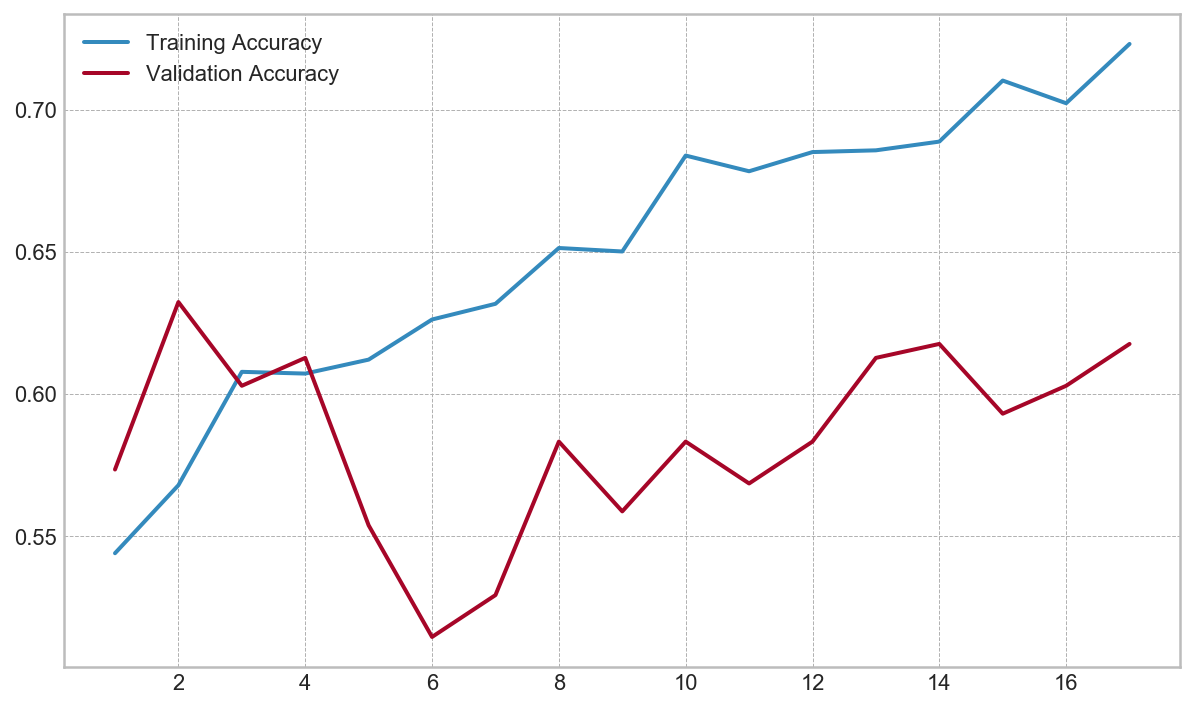

In [165]:
# Evaluate model, test accuracy, confustion matrix etc..
plot_training(loaded_history)
conf_matrix(cnn1_optimal, test)
class_report(cnn1_optimal, test)

> We see this is not that much better than the baseline on the test set despite being 10% higher than baseline on the validation set

In [91]:
easy_accuracy = test_on_difficulty(cnn1_optimal, test_dir, dif='easy', img_shape=img_shape, tests=1000)
mid_accuracy = test_on_difficulty(cnn1_optimal, test_dir, dif='mid', img_shape=img_shape, tests=1000)
hard_accuracy = test_on_difficulty(cnn1_optimal, test_dir, dif='hard', img_shape=img_shape, tests=1000)

In [103]:
print('Accuracy on easy pictures', easy_accuracy)
print('Accuracy on medium pictures', mid_accuracy)
print('Accuracy on hard pcitures', hard_accuracy)

Accuracy on easy pictures 0.556
Accuracy on medium pictures 0.673
Accuracy on hard pcitures 0.629


In [114]:
from scikitplot.metrics import plot_roc, plot_precision_recall

In [188]:
test_data = test[0]
X = test_data[0]
ground_truths = test_data[1]
real_probs = cnn1_optimal.predict(X)

In [189]:
fake_probs = 1 - real_probs

In [190]:
test_probs = np.array([fake_probs.flatten(), real_probs.flatten(),])

In [191]:
test_probs.T

array([[0.66140187, 0.3385981 ],
       [0.52336305, 0.47663695],
       [0.77980405, 0.22019595],
       [0.67140603, 0.328594  ],
       [0.6912613 , 0.3087387 ],
       [0.51953316, 0.48046687],
       [0.6364494 , 0.3635506 ],
       [0.7016313 , 0.2983687 ],
       [0.5996941 , 0.40030593],
       [0.48191607, 0.51808393],
       [0.18760347, 0.8123965 ],
       [0.42564595, 0.57435405],
       [0.46368742, 0.5363126 ],
       [0.463089  , 0.536911  ],
       [0.58967155, 0.41032845],
       [0.30526495, 0.69473505],
       [0.7178067 , 0.2821933 ],
       [0.49764907, 0.5023509 ],
       [0.89172554, 0.10827443],
       [0.66476434, 0.33523566],
       [0.4177711 , 0.5822289 ],
       [0.23290527, 0.76709473],
       [0.38618016, 0.61381984],
       [0.38633072, 0.6136693 ],
       [0.63066196, 0.36933807],
       [0.28769958, 0.7123004 ],
       [0.35622323, 0.6437768 ],
       [0.7362447 , 0.26375532],
       [0.5185034 , 0.48149657],
       [0.8301412 , 0.16985881],
       [0.

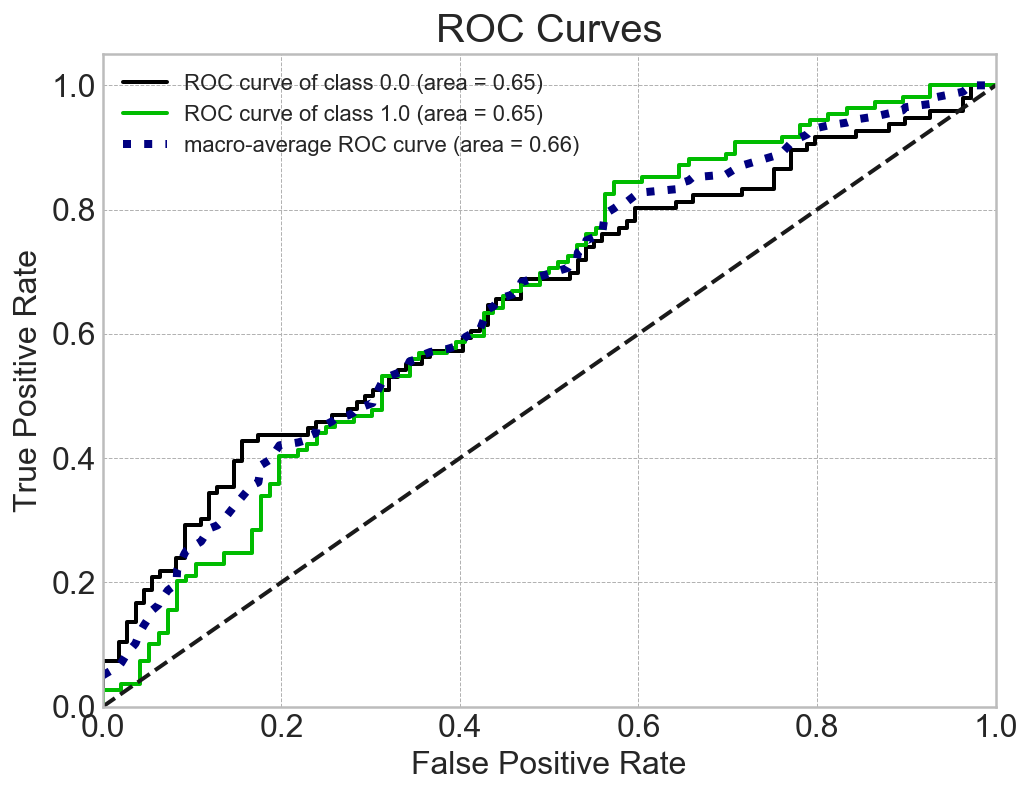

In [193]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set()
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

Y_prob_pred = test_probs.T


plot_roc(ground_truths, Y_prob_pred, ax= ax, title_fontsize=20, text_fontsize=16, plot_micro=False)
plt.legend(framealpha=0);

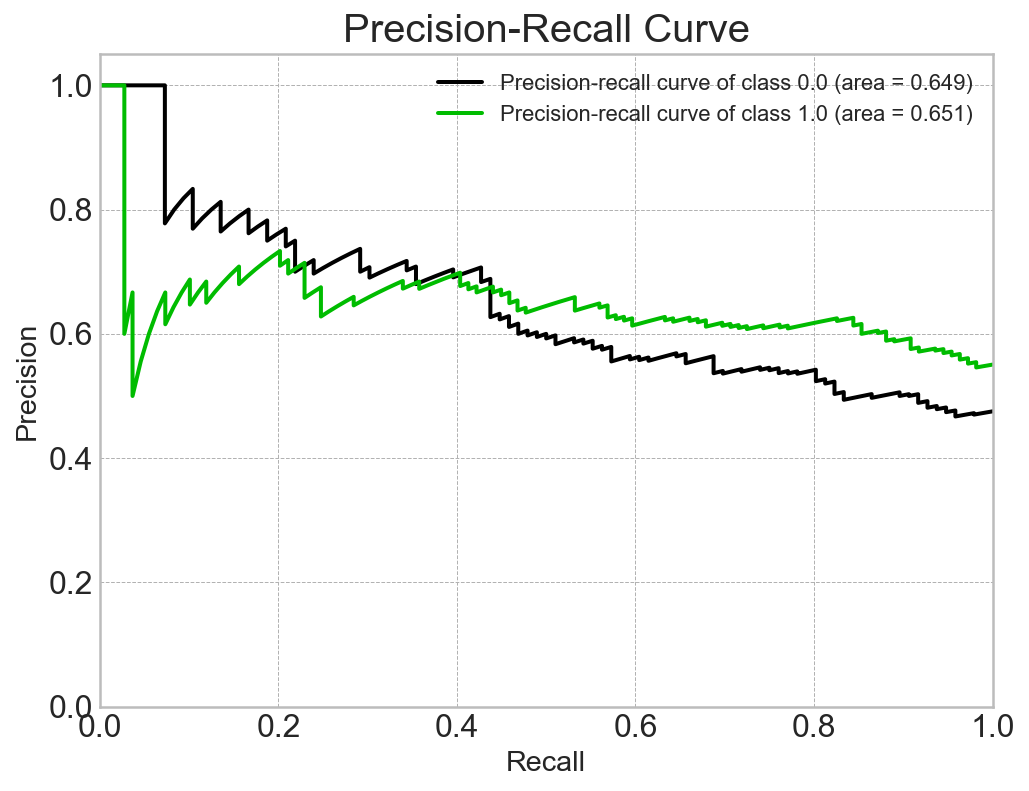

In [195]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plot_precision_recall(ground_truths, Y_prob_pred, ax=ax, title_fontsize=20, text_fontsize=16, plot_micro=False)
plt.legend(framealpha=0);

### CNN 2
This model aims to improve upon the previous by adding more convolutional filters in the higher levels of the network and additional adding another dense layer

In [98]:
# Model parameters
model_name = 'cnn2'
loss = 'binary_crossentropy'
dropout = 0.1
#learning_rate = 0.02
img_shape = (64, 64, 3)

train_args = {
    'rotation_range': 0,
    'height_shift_range': 0.05,
    'width_shift_range':0.05,
    'horizontal_flip': True,
    'brightness_range': [1.1, 0.9],
    'zoom_range': [1.0, 1.0]
}



# Load data with function defined above
train, val, test = load_data(train_dir,
                             val_dir,
                             test_dir,
                             train_batch_size=16,
                             val_batch_size=16,
                             test_batch_size=n_test,
                             img_shape=img_shape,
                             train_args=train_args,
                             )

# try selu, batch normalisation (decreases the coefficents after each batch), initialisation schemes,
# Specify the model structure
cnn2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3),
                           activation='selu',
                           input_shape=img_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='selu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='selu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='selu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam()
cnn2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=40)

# Setup a model checkpoint to save our best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'{model_dir}/{model_name}.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
)

Found 1632 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [99]:
model_fit = cnn2.fit_generator(train, 
                             epochs = 400, 
                             validation_data = val, 
                             callbacks=[checkpoint, es])

Epoch 1/400
101/102 [============================>.] - ETA: 0s - loss: 1.0816 - accuracy: 0.5458
Epoch 00001: val_accuracy improved from -inf to 0.56373, saving model to ../models/cnn2.h5
102/102 [==============================] - 30s 293ms/step - loss: 1.0783 - accuracy: 0.5466 - val_loss: 0.9328 - val_accuracy: 0.5637
Epoch 2/400
101/102 [============================>.] - ETA: 0s - loss: 0.7722 - accuracy: 0.5903
Epoch 00002: val_accuracy improved from 0.56373 to 0.60294, saving model to ../models/cnn2.h5
102/102 [==============================] - 28s 275ms/step - loss: 0.7716 - accuracy: 0.5901 - val_loss: 0.7387 - val_accuracy: 0.6029
Epoch 3/400
101/102 [============================>.] - ETA: 0s - loss: 0.7208 - accuracy: 0.5996
Epoch 00003: val_accuracy did not improve from 0.60294
102/102 [==============================] - 29s 280ms/step - loss: 0.7200 - accuracy: 0.5999 - val_loss: 0.8517 - val_accuracy: 0.5833
Epoch 4/400
101/102 [============================>.] - ETA: 0s - lo

101/102 [============================>.] - ETA: 0s - loss: 0.4115 - accuracy: 0.8094
Epoch 00029: val_accuracy did not improve from 0.62745
102/102 [==============================] - 35s 338ms/step - loss: 0.4102 - accuracy: 0.8107 - val_loss: 0.9090 - val_accuracy: 0.5735
Epoch 30/400
101/102 [============================>.] - ETA: 0s - loss: 0.4066 - accuracy: 0.8100
Epoch 00030: val_accuracy did not improve from 0.62745
102/102 [==============================] - 36s 355ms/step - loss: 0.4059 - accuracy: 0.8100 - val_loss: 1.0115 - val_accuracy: 0.5637
Epoch 31/400
101/102 [============================>.] - ETA: 0s - loss: 0.4075 - accuracy: 0.8007
Epoch 00031: val_accuracy did not improve from 0.62745
102/102 [==============================] - 35s 339ms/step - loss: 0.4070 - accuracy: 0.8009 - val_loss: 0.9755 - val_accuracy: 0.6127
Epoch 32/400
101/102 [============================>.] - ETA: 0s - loss: 0.3939 - accuracy: 0.8144
Epoch 00032: val_accuracy did not improve from 0.62745

In [100]:
# Save the model fit history
joblib.dump(model_fit.history, f'{model_dir}/{model_name}_history')

['../models/cnn2_history']

In [101]:
# Load the best model from the call back and the training history
cnn2_optimal = tf.keras.models.load_model(f'{model_dir}/{model_name}.h5')
history = joblib.load(f'{model_dir}/{model_name}_history')

,Predicted Fake,Predicted Real
Actual Fake,59,37
Actual Real,45,64


              precision    recall  f1-score   support

        fake       0.57      0.61      0.59        96
        real       0.63      0.59      0.61       109

    accuracy                           0.60       205
   macro avg       0.60      0.60      0.60       205
weighted avg       0.60      0.60      0.60       205



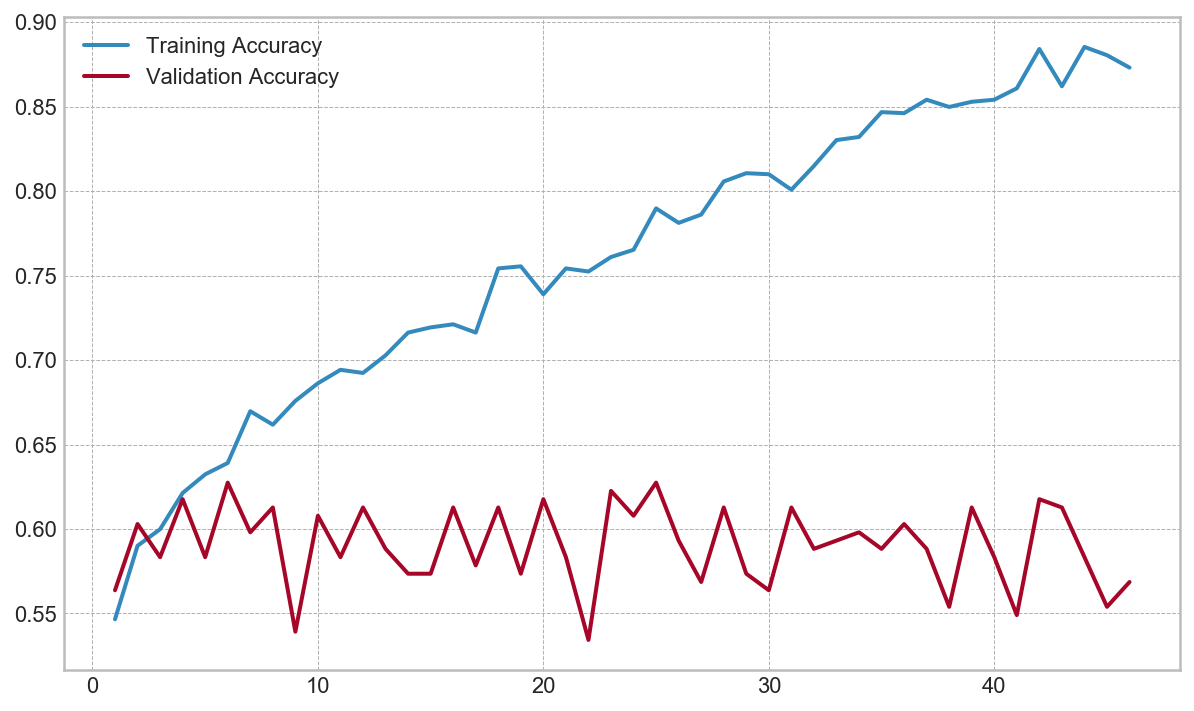

In [157]:
# Evaluate model, test accuracy, confustion matrix etc..
plot_training(history)
conf_matrix(cnn2_optimal, test)
class_report(cnn2_optimal, test)

> This model actually performed worse than the previous one


### CNN3

In [169]:
# Model parameters
model_name = 'cnn3'
loss = 'binary_crossentropy'
dropout = 0.1
#learning_rate = 0.02
img_shape = (64, 64, 3)

train_args = {
    'rotation_range': 0,
    'height_shift_range': 0.05,
    'width_shift_range':0.05,
    'horizontal_flip': True,
    'brightness_range': [1.1, 0.9],
    'zoom_range': [1.0, 1.0]
}



# Load data with function defined above
train, val, test = load_data(train_dir,
                             val_dir,
                             test_dir,
                             train_batch_size=16,
                             val_batch_size=16,
                             test_batch_size=n_test,
                             img_shape=img_shape,
                             train_args=train_args,
                             )

# try selu, batch normalisation (decreases the coefficents after each batch), initialisation schemes,
# Specify the model structure
cnn3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3),
                           activation='selu',
                           input_shape=img_shape, kernel_regularizer='l2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='selu',kernel_regularizer='l2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='selu', kernel_regularizer='l2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='selu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam()
cnn3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=20)

# Setup a model checkpoint to save our best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'{model_dir}/{model_name}.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
)

Found 1632 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [170]:
model_fit = cnn3.fit_generator(train, 
                             epochs = 400, 
                             validation_data = val, 
                             callbacks=[checkpoint, es])

Epoch 1/400
101/102 [============================>.] - ETA: 0s - loss: 1.8460 - accuracy: 0.5390
Epoch 00001: val_accuracy improved from -inf to 0.52451, saving model to ../models/cnn3.h5
102/102 [==============================] - 43s 423ms/step - loss: 1.8449 - accuracy: 0.5380 - val_loss: 1.5091 - val_accuracy: 0.5245
Epoch 2/400
101/102 [============================>.] - ETA: 0s - loss: 1.4459 - accuracy: 0.5575
Epoch 00002: val_accuracy did not improve from 0.52451
102/102 [==============================] - 35s 344ms/step - loss: 1.4476 - accuracy: 0.5558 - val_loss: 1.3227 - val_accuracy: 0.4951
Epoch 3/400
101/102 [============================>.] - ETA: 0s - loss: 1.2969 - accuracy: 0.5774
Epoch 00003: val_accuracy improved from 0.52451 to 0.59314, saving model to ../models/cnn3.h5
102/102 [==============================] - 31s 304ms/step - loss: 1.2943 - accuracy: 0.5797 - val_loss: 1.1602 - val_accuracy: 0.5931
Epoch 4/400
101/102 [============================>.] - ETA: 0s - lo

In [3]:
cnn3.evaluate_generator(test)

NameError: name 'cnn3' is not defined

In [6]:
sys.path.append()

['/Users/edwardrees/Google Drive/GA/Capstone/fake_vs_real/notebooks',
 '/Users/edwardrees/opt/miniconda3/envs/capstone/lib/python37.zip',
 '/Users/edwardrees/opt/miniconda3/envs/capstone/lib/python3.7',
 '/Users/edwardrees/opt/miniconda3/envs/capstone/lib/python3.7/lib-dynload',
 '',
 '/Users/edwardrees/opt/miniconda3/envs/capstone/lib/python3.7/site-packages',
 '/Users/edwardrees/opt/miniconda3/envs/capstone/lib/python3.7/site-packages/IPython/extensions',
 '/Users/edwardrees/.ipython']

In [2]:
import sys

In [3]:
sys.path.append('../src')

In [5]:
import models as md

In [10]:
md.cnn1.name = 'hello'

AttributeError: Can't set the attribute "name", likely because it conflicts with an existing read-only @property of the object. Please choose a different name.

## Transfer learning

### Mobile Net V2 Base

In [197]:
# Model parameters
# Model parameters
model_name = 'mnv2'
loss = 'binary_crossentropy'
dropout = 0.2
#learning_rate = 0.02
img_shape = (128, 128, 3)

train_args = {'rotation_range': 45,
              'height_shift_range':0.2,
              'horizontal_flip': True,
              'brightness_range': [0.8,1.2],
              'zoom_range': [0.8, 1.2]}

# Load data with function defined above
train, val, test = load_data(train_batch_size=16,
                             val_batch_size=16, 
                             test_batch_size=n_test, 
                             img_shape=img_shape, 
                             train_args=train_args)


# Initalize the MobileNetV2 model that will for the base for our classifier
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=img_shape,
                          include_top=False,
                          weights='imagenet'
                          )

top_n_blocks_to_train = 3
base_model = make_k_layers_trainable(base_model, 2+top_n_blocks_to_train*9)

Found 1632 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [204]:
base_model.layers[5]

<function tensorflow.python.keras.activations.linear>

In [0]:
mnv2_1 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(2, activation='softmax')
])

	
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Setup a model checkpoint to save our best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{model_dir}/{model_name}.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,)


mnv2_1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [166]:
model_fit = mnv2_1.fit_generator(train,
                    epochs=20, 
                    validation_data = val, 
                    callbacks = [checkpoint])

# Save the model fit history
joblib.dump(model_fit.history, f'{model_dir}/{model_name}_history')

Epoch 1/20
101/102 [============================>.] - ETA: 0s - loss: 0.7431 - accuracy: 0.5507
Epoch 00001: val_accuracy improved from -inf to 0.49756, saving model to drive/My Drive/GA/Capstone/models/mnv2.h5
102/102 [==============================] - 44s 434ms/step - loss: 0.7419 - accuracy: 0.5527 - val_loss: 0.6982 - val_accuracy: 0.4976
Epoch 2/20
101/102 [============================>.] - ETA: 0s - loss: 0.6452 - accuracy: 0.6374
Epoch 00002: val_accuracy did not improve from 0.49756
102/102 [==============================] - 41s 400ms/step - loss: 0.6441 - accuracy: 0.6385 - val_loss: 0.8388 - val_accuracy: 0.4683
Epoch 3/20
101/102 [============================>.] - ETA: 0s - loss: 0.6244 - accuracy: 0.6541
Epoch 00003: val_accuracy did not improve from 0.49756
102/102 [==============================] - 41s 400ms/step - loss: 0.6247 - accuracy: 0.6532 - val_loss: 1.0233 - val_accuracy: 0.4634
Epoch 4/20
101/102 [============================>.] - ETA: 0s - loss: 0.6280 - accura

['drive/My Drive/GA/Capstone/models/mnv2_history']

In [0]:
# Load the best model from the call back and the training history
mnv2_1_optimal = tf.keras.models.load_model(f'{model_dir}/{model_name}.h5')
history = joblib.load(f'{model_dir}/{model_name}_history')

,Predicted Fake,Predicted Real
Actual Fake,11,85
Actual Real,6,102


              precision    recall  f1-score   support

        fake       0.65      0.11      0.19        96
        real       0.55      0.94      0.69       108

    accuracy                           0.55       204
   macro avg       0.60      0.53      0.44       204
weighted avg       0.59      0.55      0.46       204



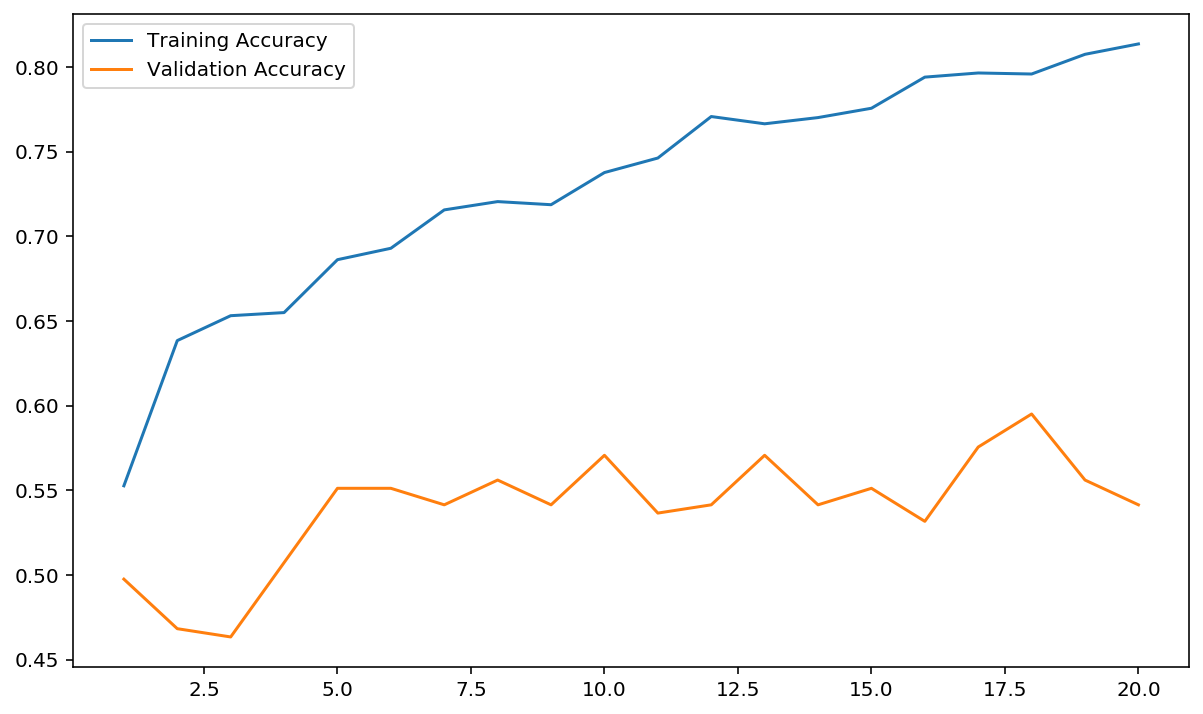

In [169]:
# Evaluate model, test accuracy, confustion matrix etc..
plot_training(history)
conf_matrix(mnv2_1_optimal, test)
class_report(mnv2_1_optimal, test)

### VGG16 pretrainined on imagenet

In [190]:
# Model parameters
model_name='vgg16'
loss = 'binary_crossentropy'
dropout = 0.1
#learning_rate = 0.02
img_shape = (224, 224, 3)

train_args = {'rotation_range': 45,
              'height_shift_range':0.2,
              'width_shift_range':0.1,
              'horizontal_flip': True,
              'brightness_range': [0.8,1.2],
              'zoom_range': [0.8, 1.2]}

# Load data with function defined above
train, val, test = load_data(train_batch_size=16,
                             val_batch_size=16, 
                             test_batch_size=n_test, 
                             img_shape=img_shape)


# Define the base model
base_model = tf.keras.applications.vgg16.VGG16(include_top=False, 
                                            weights='imagenet', 
                                            input_tensor=None, 
                                            input_shape=img_shape, 
                                            pooling=None, 
                                            classes=2)


# Freeze the model excpet for the top 3 blocks (4 layers per block)
n_blocks_to_train = 3
k = 4*n_blocks_to_train
base_model = make_k_layers_trainable(base_model, k)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setup a model checkpoint to save our best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{model_dir}/{model_name}.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,)

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=7)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss= loss,
              metrics=['accuracy'])



Found 1632 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [184]:
vgg16_fit = model.fit_generator(train,
                              epochs=20, 
                              validation_data = val,
                              callbacks = [checkpoint, es])

Epoch 1/20
101/102 [============================>.] - ETA: 0s - loss: 0.8010 - accuracy: 0.5012
Epoch 00001: val_accuracy improved from -inf to 0.53171, saving model to drive/My Drive/GA/Capstone/models/vgg16.h5
102/102 [==============================] - 68s 665ms/step - loss: 0.7998 - accuracy: 0.5025 - val_loss: 0.7140 - val_accuracy: 0.5317
Epoch 2/20
101/102 [============================>.] - ETA: 0s - loss: 0.7876 - accuracy: 0.5056
Epoch 00002: val_accuracy did not improve from 0.53171
102/102 [==============================] - 67s 653ms/step - loss: 0.7865 - accuracy: 0.5092 - val_loss: 0.6917 - val_accuracy: 0.5317
Epoch 3/20
101/102 [============================>.] - ETA: 0s - loss: 0.6917 - accuracy: 0.5297
Epoch 00003: val_accuracy did not improve from 0.53171
102/102 [==============================] - 66s 649ms/step - loss: 0.6917 - accuracy: 0.5294 - val_loss: 0.6912 - val_accuracy: 0.5317
Epoch 4/20
101/102 [============================>.] - ETA: 0s - loss: 0.6913 - accur

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [185]:
# Save the model fit history
joblib.dump(vgg16_fit.history, f'{model_dir}/{model_name}_history')

['drive/My Drive/GA/Capstone/models/vgg16_history']

In [0]:
# Load the best model from the call back and the training history
vgg16_optimal = tf.keras.models.load_model(f'{model_dir}/{model_name}.h5')
history = joblib.load(f'{model_dir}/{model_name}_history')

,Predicted Fake,Predicted Real
Actual Fake,0,96
Actual Real,0,108


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        fake       0.00      0.00      0.00        96
        real       0.53      1.00      0.69       108

    accuracy                           0.53       204
   macro avg       0.26      0.50      0.35       204
weighted avg       0.28      0.53      0.37       204



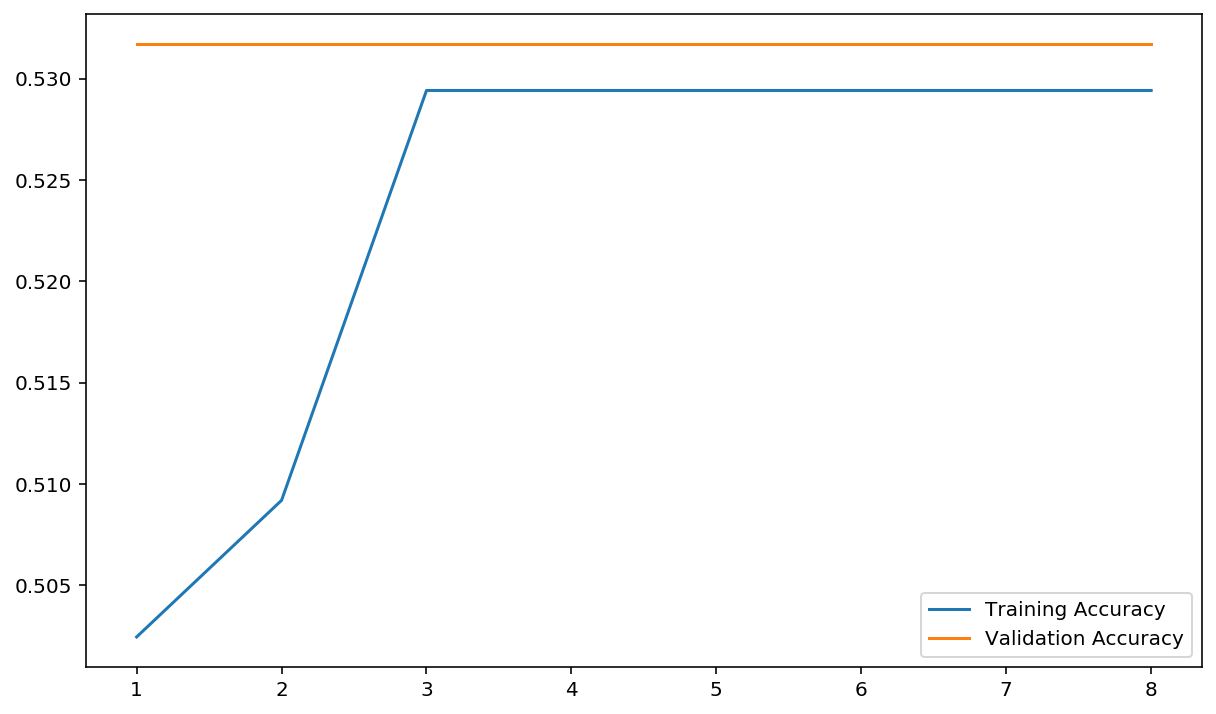

In [187]:
# Evaluate model, test accuracy, confustion matrix etc..
plot_training(history)
conf_matrix(vgg16_optimal, test)
class_report(vgg16_optimal, test)

### Resnet50 pretrained on vgg-face-dataset

In [0]:
vgg_face_weights = f'{dir_}/models/resnet50_softmax_dim512/weights.h5'

In [0]:
vgg_face_model = tf.keras.models.load_model(vgg_face_weights)

In [0]:
layers_to_remove = 3
base_model = tf.keras.Model(vgg_face_model.input, vgg_face_model.layers[-(layers_to_remove+1)].output)

In [194]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [0]:
def scheduler(epoch):
    if epoch <= 3:
        return 0.008
    elif epoch > 3 and epoch <= 15:
        return 0.004000 
    else:
        return 0.0025

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [196]:
# Model parameters
model_name='resnet50'
loss = 'binary_crossentropy'
dropout = 0.1
#learning_rate = 0.02
img_shape = (224, 224, 3)


# Freeze the model excpet for the top 3 blocks (4 layers per block)
#n_blocks_to_train = 3
k = 20
base_model = make_k_layers_trainable(base_model, k)


train_args = {'rotation_range': 45,
              'height_shift_range':0.2,
              'width_shift_range':0.1,
              'horizontal_flip': True,
              'brightness_range': [0.8,1.2],
              'zoom_range': [0.8, 1.2]}


model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

	
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Setup a model checkpoint to save our best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{model_dir}/{model_name}.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'],)

resnet50_fit = model.fit_generator(train,
                              epochs=10, 
                              validation_data = val, 
                              callbacks=[es, lr_callbacks, checkpoint])


Epoch 1/10
101/102 [============================>.] - ETA: 0s - loss: 1.0277 - accuracy: 0.5792
Epoch 00001: val_accuracy improved from -inf to 0.46829, saving model to drive/My Drive/GA/Capstone/models/resnet50.h5
102/102 [==============================] - 66s 649ms/step - loss: 1.0280 - accuracy: 0.5784 - val_loss: 2.2462 - val_accuracy: 0.4683
Epoch 2/10
101/102 [============================>.] - ETA: 0s - loss: 0.8481 - accuracy: 0.6541
Epoch 00002: val_accuracy did not improve from 0.46829
102/102 [==============================] - 65s 633ms/step - loss: 0.8478 - accuracy: 0.6538 - val_loss: 2.0131 - val_accuracy: 0.4683
Epoch 3/10
101/102 [============================>.] - ETA: 0s - loss: 0.8258 - accuracy: 0.6986
Epoch 00003: val_accuracy did not improve from 0.46829
102/102 [==============================] - 64s 630ms/step - loss: 0.8261 - accuracy: 0.6979 - val_loss: 1.6423 - val_accuracy: 0.4683
Epoch 4/10
101/102 [============================>.] - ETA: 0s - loss: 0.7255 - ac

ResourceExhaustedError: ignored

In [0]:
# Save the model fit history
joblib.dump(resnet50_fit.history, f'{model_dir}/{model_name}_history')